In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt



In [2]:
from sktime.datasets import load_from_tsfile_to_dataframe
from torch.utils.data import Dataset, DataLoader

# Load training and test data
X_train, y_train = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TEST.ts")
y_train=np.array(y_train,'float')
y_test=np.array(y_test,'float')

mean=y_train.mean()
std=y_train.std()
y_train=(y_train-mean)/std
y_test=(y_test-mean)/std

In [3]:
def df_to_np(X):
    return np.stack([
        np.stack(row.values)  # stack channels
        for _, row in X.iterrows()  # iterate over samples
    ])


In [4]:
X_train_tmp_np=df_to_np(X_train)
X_test_tmp_np=df_to_np(X_test)

#y_train_np=df_to_np(y_train)

In [5]:
X_train_tmp_np0=X_train_tmp_np#[:,0:2,:]
X_test_tmp_np0=X_test_tmp_np#[:,0:2,:]

In [6]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs, lowcut=0.5, highcut=5, order=4):
    nyq = fs / 2
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [20]:
def preprocess_ppg(signal, clip_range=(-100, 100), apply_bp=True):
    # 1. Clip outliers
    clipped = np.clip(signal, clip_range[0], clip_range[1])
    if apply_bp:
        clipped=bandpass_filter(clipped, 125)

    # 2. Normalize: zero mean, unit variance
    mean = clipped.mean()
    std = clipped.std()
    if std == 0:
        std = 1  # avoid division by zero
    normalized = (clipped - mean) / std
    
    return normalized

In [24]:
def preprocess_mat(X):
    shape=X.shape
    plot=False
    nu_samples=shape[0]
    nu_features=shape[1]
    for fea in range(nu_features):
        for i in range(nu_samples):
            if fea>=2:
                apply_bp=True
            else:
                apply_bp=False
                
            preprocessed=preprocess_ppg(signal=X[i,fea,:], apply_bp=apply_bp)
            X[i,fea,:]=preprocessed
            if plot==True:
                fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column
                axes[0].plot(preprocessed)   
                axes[1].plot(X_train_tmp_np[i,0,:])
                plt.show()
                input('a')
    return X
    

In [25]:
X_train_tmp_np=preprocess_mat(X_train_tmp_np0)
X_test_tmp_np=preprocess_mat(X_test_tmp_np0)

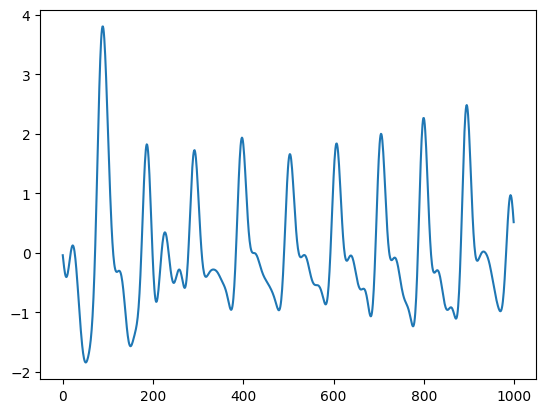

In [26]:
#print(X_train_np.shape)
#print("X np start", X_train_np[0,0,:5])
batch_size=1000


def make_batches(X_np):
    shape = X_np.shape  # (samples, features, time)
    nu_samples = shape[0]
    nu_features = shape[1]
    nu_time_steps = shape[2]

    assert nu_time_steps % batch_size == 0, "Time steps must be divisible by batch size"
    nu_split_batches = nu_time_steps // batch_size
    nu_batches = nu_samples * nu_split_batches

    # Reshape: (samples, features, split_batches, batch_size)
    X_np_new = X_np.reshape(nu_samples, nu_features, nu_split_batches, batch_size)
    X_np_new = X_np_new.transpose(0, 2, 1, 3)  # (samples, split_batches, features, batch_size)
    X_np_new = X_np_new.reshape(nu_batches, nu_features, batch_size)

    return X_np_new, nu_time_steps, nu_samples

X_train_np, nu_time_steps, nu_samples=make_batches(X_train_tmp_np)
X_test_np, nu_time_steps, nu_samples=make_batches(X_test_tmp_np)

#print(X_np_new.shape)
#print("X np new start", X_np_new[0,0,:5])
#print(X_train_np[1,0,:10])
#print(X_np_new[10,0,:5])
plt.plot(X_train_np[0,0,:])
#plt.plot(X_train_tmp_np[0,0,:])

In [27]:
def make_batch_target(y):
    y_out=[]
    for item in y:
        for i in range(int(nu_time_steps/batch_size)):
            y_out.append(item)
    return np.array(y_out,'float')
    
y_train_np=make_batch_target(y_train)
y_test_np=make_batch_target(y_test)

In [28]:
print(X_train_np.shape)
print(y_train_np.shape)
print(X_test_np.shape)
print(y_test_np.shape)
print(y_train.shape)
int(nu_time_steps/batch_size)


(1768, 5, 1000)
(1768,)
(1328, 5, 1000)
(1328,)
(1768,)


1

In [35]:
# Train/test split
#n_samples = 1000

#split = int(0.8 * n_samples)
#X_train, X_test = X[:split], X[split:n_samples]
#y_train, y_test = y[:split], y[split:n_samples]
# Convert X_train DataFrame to a NumPy array
#X_train_np = np.array([row.values for _, row in X_train.iterrows()])
#y_train_np = np.array(y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=1024, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor))


In [36]:
y_train_np.shape

(1768,)

In [37]:
def torch_plotter(output_tensor):
    channel_to_plot = output_tensor[0, 0, :].detach().numpy()  # Detach from the graph to avoid tracking gradients
    
    # Plotting the first channel's output over time steps
    plt.plot(channel_to_plot)
    plt.title("Output of Conv1D - First Channel")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.show()

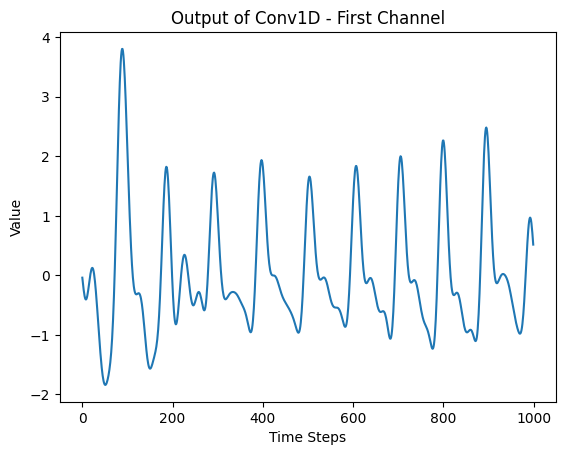

In [38]:
torch_plotter(X_train_tensor)

In [39]:

# 2. Define CNN model
class PPGCNN(nn.Module):
    def __init__(self):
        super(PPGCNN, self).__init__()
        out_channels=30
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=out_channels, kernel_size=200, padding=5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))      # [B, 16, 100]
        x = self.dropout(x)               # Apply dropout after activation
        x = self.pool(x)                  # [B, 16, 1]
        x = x.view(x.size(0), -1)         # [B, 16]
        x = self.fc(x)                    # [B, 1]
        return x



In [40]:
# 3. Train the model
model = PPGCNN()
#model = PPGTransformer()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        #print(xb.shape)
        #input('a')
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if np.mod(epoch,2)==0:
        # 4. Evaluate
        model.eval()
        with torch.no_grad():
            preds = model(X_test_tensor).squeeze().numpy()*std+mean
            targets = y_test_tensor.squeeze().numpy()*std+mean
            mae = np.mean(np.abs(preds - targets))
            print(f"\nTest MAE: {mae:.2f} bpm")
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss:.2f}")



Test MAE: 17.96 bpm
Epoch 1/100, Loss: 39.89
Epoch 2/100, Loss: 20.22

Test MAE: 17.55 bpm
Epoch 3/100, Loss: 17.07
Epoch 4/100, Loss: 15.08

Test MAE: 17.01 bpm
Epoch 5/100, Loss: 13.81
Epoch 6/100, Loss: 12.83

Test MAE: 17.40 bpm
Epoch 7/100, Loss: 11.44
Epoch 8/100, Loss: 11.20

Test MAE: 17.41 bpm
Epoch 9/100, Loss: 11.37
Epoch 10/100, Loss: 10.13

Test MAE: 17.52 bpm
Epoch 11/100, Loss: 9.49
Epoch 12/100, Loss: 9.71

Test MAE: 18.82 bpm
Epoch 13/100, Loss: 9.28
Epoch 14/100, Loss: 8.79

Test MAE: 17.44 bpm
Epoch 15/100, Loss: 8.47
Epoch 16/100, Loss: 8.46

Test MAE: 17.89 bpm
Epoch 17/100, Loss: 8.52
Epoch 18/100, Loss: 8.52


KeyboardInterrupt: 

In [ ]:
# 4. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_train_tensor).squeeze().numpy()*std+mean
    targets = y_train_tensor.squeeze().numpy()*std+mean
    mae = np.mean(np.abs(preds - targets))
    print(f"\nTest MAE: {mae:.2f} bpm")

In [ ]:
# 4. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()*std+mean
    targets = y_test_tensor.squeeze().numpy()*std+mean
    mae = np.mean(np.abs(preds - targets))
    print(f"\nTest MAE: {mae:.2f} bpm")

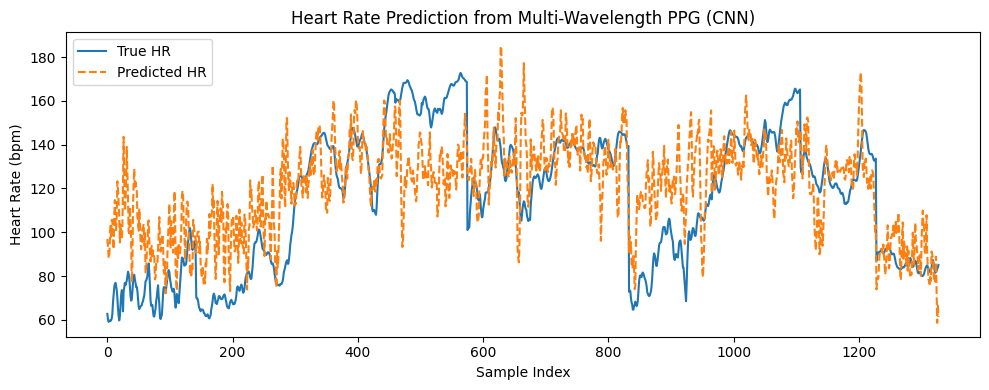

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [26]:
# 5. Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(targets, label="True HR")
plt.plot(preds, label="Predicted HR", linestyle='--')
plt.title("Heart Rate Prediction from Multi-Wavelength PPG (CNN)")
plt.xlabel("Sample Index")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()  # Clear the figure to avoid any interference with the next plot
plt.figure(figsize=(10, 4))

# 6. Plot PPG data
for i in range(100):
    if np.max(np.abs(X_train_np[i,0,:]))>200:
        plt.plot(X_train_np[i,0,:], label="PPG Signal")  # Assuming X is your input PPG data
        plt.title("PPG Signal for Sample 0")
        plt.xlabel("Sample Index")
        plt.ylabel("PPG Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.show()  # Display the second plot
        print(i)
        input('a')

In [26]:
X_train.shape

(1768, 5)